In [1]:
import matplotlib.pyplot as plt
import random
import math
import numpy as np
import pandas as pd

# Ensuring reproducibility
random.seed(42)
np.random.seed(42)

## Congifuration and parameters

In [2]:
# Configuration
CONFIG = {
    "BASE_LEGITIMACY_List": [0.2, 0.4, 0.6, 0.8],
    "iterations": 100 ,
    "max_time_steps": 50,
    "initial_agent_vision_cases": ['High', 'Low'],
    "shock_rate_cases": ['High', 'Low'],
    "cops_ratio_cases": ['High']
}

# Parameters
Quality_of_life_index = 50
Corruption_perceptions_index = 50
internet_disconnection = 0

# Constants
SHOCK_RATE = 5
COPS_RATIO = 20
REVOLUTION_THRESHOLD = 0.35

# Global variables
BASE_LEGITIMACY = ((Quality_of_life_index / 79 * 100) + (Corruption_perceptions_index / 90 * 100)) / 200
legitimacy = BASE_LEGITIMACY
delta_legitimacy = 0
world_status = 0
initial_agent_vision = 2
agent_vision = initial_agent_vision
government_utility = 1
reform_value = 0
protestors_ratio = 0.0
indirect_reform = 0
shock_is_happening = False
active_agents = 0
jailed_agents = 0
killed_agents = 0

## Citizens Class

In [3]:
class Agent:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.risk_aversion = random.random()
        self.rage = random.random()
        self.status = "quiet"
        self.vision = initial_agent_vision
        self.jailed_time = 0
        self.neighbor_killed = 0
        self.neighbor_active = 0
        self.neighbor_jailed = 0

    def update_status(self, agents):
        global legitimacy, internet_disconnection, protestors_ratio, reform_value, shock_is_happening, indirect_reform
        self.neighbor_killed_1 = len([agent for agent in agents if agent.status == "killed" and
                                abs(agent.x - self.x) <= self.vision and abs(agent.y - self.y) <= self.vision])
        self.neighbor_active_1 = len([agent for agent in agents if agent.status == "active" and
                                abs(agent.x - self.x) <= self.vision and abs(agent.y - self.y) <= self.vision])
        self.neighbor_jailed_1 = len([agent for agent in agents if agent.status == "jailed" and
                                abs(agent.x - self.x) <= self.vision and abs(agent.y - self.y) <= self.vision])

        self.stimuli = (self.neighbor_killed_1 - self.neighbor_killed) * 0.08 + (self.neighbor_jailed_1 - self.neighbor_jailed) * 0.01 + (self.neighbor_active_1 - self.neighbor_active) * 0.003

        if random.random() * 100 < SHOCK_RATE:
            shock_is_happening = 1
        else:
            shock_is_happening = 0

        self.rage += self.stimuli + shock_is_happening * random.gauss(0.02, 0.03) - reform_value
        self.risk_aversion += (self.neighbor_killed_1 - self.neighbor_killed) * 0.1 + (self.neighbor_jailed_1 - self.neighbor_jailed) * 0.005 - reform_value * (1- 0.4 *indirect_reform)

        self.neighbor_killed = self.neighbor_killed_1
        self.neighbor_active = self.neighbor_active_1
        self.neighbor_jailed = self.neighbor_jailed_1

        self.condition = self.rage - self.risk_aversion - legitimacy
        if self.status == "jailed":
            self.jailed_time -= 1
            if self.jailed_time <= 0:
                if self.condition > 0:
                    self.status = "active"
                else:
                    self.status = "quiet"
        else:
            if self.status == "quiet" or self.status == "active":
                if self.condition > 0.0:
                    self.status = "active"
                else:
                    self.status = "quiet"

        if internet_disconnection == 1:
            if REVOLUTION_THRESHOLD - protestors_ratio <= 0.1:
                self.vision = 2
            else:
                self.vision = initial_agent_vision
        else:
            self.vision = initial_agent_vision


## Cops Class

In [4]:
class Cop:
    def __init__(self, x, y):
        global initial_agent_vision, legitimacy, protestors_ratio
        self.x = x
        self.y = y
        self.vision = round(initial_agent_vision * 1.5)
        self.violence_level = random.random() * ((1 - legitimacy) * (protestors_ratio + 0.001))

    def suppress(self, agents):
        global legitimacy, protestors_ratio
        self.nearby_active_agents = [agent for agent in agents if agent.status == "active" and
                                abs(agent.x - self.x) <= self.vision and abs(agent.y - self.y) <= self.vision]

        self.violence_level = random.random() * ((1 - legitimacy) * (protestors_ratio + 0.001))

        if self.nearby_active_agents:
            target = random.choice(self.nearby_active_agents)
            if self.violence_level > 0.13:
                target.status = "killed"
            else:
                target.status = "jailed"
                target.jailed_time = random.randint(0, int((protestors_ratio + 0.05) * 30))

## Cops Strategies

In [5]:
def cops_suppress(cops, agents):
    for cop in cops:
        cop.suppress(agents)

def cops_reform(cops, agents):
    global government_utility, reform_value
    reform_value = protestors_ratio * 0.2  # Calculate reform value based on some metric

def cops_contingent_suppress_low(cops, agents):
    global protestors_ratio
    if protestors_ratio < 0.30:
        cops_suppress(cops, agents)
    else:
        cops_reform(cops, agents)

def cops_contingent_suppress_high(cops, agents):
    global protestors_ratio
    if protestors_ratio >= 0.30:
        cops_suppress(cops, agents)
    else:
        cops_reform(cops, agents)

def cops_mixed(cops, agents):
    cops_suppress(cops, agents)
    cops_reform(cops, agents)

def cops_suppress_ind_reform(cops, agents):
    global indirect_reform, reform_value, protestors_ratio
    cops_suppress(cops, agents)
    if protestors_ratio < 0.20:
        indirect_reform = 1
        reform_value = protestors_ratio * 0.2
    else:
        indirect_reform = 0

## World Setup

In [6]:
def setup():
    global COPS_RATIO
    agents = []
    cops = []

    # Create agents
    total_patches = 400  # Assuming 20x20 grid
    agent_patches = 0.8 * total_patches
    cop_patches = COPS_RATIO / 100 * total_patches

    while len(agents) < agent_patches:
        x = random.randint(1, 20)
        y = random.randint(1, 20)
        if (x, y) not in [(agent.x, agent.y) for agent in agents]:
            agents.append(Agent(x, y))

    # Create cops
    while len(cops) < cop_patches:
        x = random.randint(1, 20)
        y = random.randint(1, 20)
        if (x, y) not in [(agent.x, agent.y) for agent in agents] and \
                (x, y) not in [(cop.x, cop.y) for cop in cops]:
            cops.append(Cop(x, y))

    return agents, cops

## Updating the Stats

In [7]:
def update_stats(agents):
    global active_agents, jailed_agents, killed_agents
    active_agents_so_far = [agent for agent in agents if agent.status == "active"]
    jailed_agents_so_far = [agent for agent in agents if agent.status == "jailed"]
    killed_agents_so_far = [agent for agent in agents if agent.status == "killed"]

    active_agents = len(active_agents_so_far) - active_agents    # Number of active agents in this iteration
    jailed_agents = len(jailed_agents_so_far) - jailed_agents   # Number of jailed agents in this iteration
    killed_agents = len(killed_agents_so_far) - killed_agents   # Number of killed agents in this iteration

## Updating Global Variables

In [8]:
def update_globals(agents):
    global legitimacy, world_status, protestors_ratio, delta_legitimacy, reform_value, government_utility, jailed_agents, active_agents, killed_agents, REVOLUTION_THRESHOLD
    update_stats(agents)

    legitimacy_prev = legitimacy
    legitimacy = (legitimacy / (math.exp(0.05 * killed_agents + 0.02 * jailed_agents))) + reform_value * random.random()   # updating legitimacy based on number of killed and jailed agents in this iteration, the credit that it gets from reform and a random factor
    if legitimacy > 1:
        legitimacy = 1
    elif legitimacy < 0:
        legitimacy = 0

    delta_legitimacy = legitimacy_prev - legitimacy

    total_agents = sum(1 for agent in agents if agent.status == "active" or agent.status == "jailed" or agent.status == "quiet")
    active_agents_2 = sum(1 for agent in agents if agent.status == "active")
    jailed_agents_2 = sum(1 for agent in agents if agent.status == "jailed")
    active_and_jailed = active_agents_2 + jailed_agents_2
    protestors_ratio = active_and_jailed / total_agents

    world_status = 1 if protestors_ratio >= REVOLUTION_THRESHOLD else 0

    if world_status == 0:
            government_utility -= protestors_ratio * 0.1 + random.random() * delta_legitimacy + reform_value
            if government_utility > 1:
                government_utility = 1
    else:
            government_utility = 0

## Updating Citizens' Statuses

In [9]:
def update_agents_status(agents):
    for agent in agents:
        agent.update_status(agents)

## Running the Simulation

In [10]:
def run_simulation(base_legitimacy, iterations, max_time_steps, vision, shock_rate, cops_ratio, strategy_type):
    global legitimacy, initial_agent_vision, SHOCK_RATE, COPS_RATIO
    global government_utility, reform_value, protestors_ratio, indirect_reform, active_agents, jailed_agents, killed_agents, world_status

    results = []

    for iter_num in range(iterations):
        # Initialize global variables
        legitimacy = base_legitimacy
        initial_agent_vision = 4 if vision == 'Low' else 20
        SHOCK_RATE = 10 if shock_rate == 'Low' else 90
        COPS_RATIO = 5 if cops_ratio == 'Low' else 20
        government_utility = 1
        reform_value = 0
        protestors_ratio = 0.0
        indirect_reform = 0
        active_agents = 0
        jailed_agents = 0
        killed_agents = 0
        world_status = 0

        agents, cops = setup()
        time_step = 0
        gov_util_record = []
        protestors_ratio_record = []

        print(f"Iteration {iter_num+1}/{iterations}, Strategy: {strategy_type}, Legitimacy: {base_legitimacy}, Vision: {vision}, Shock Rate: {shock_rate}, Cops Ratio: {cops_ratio}")

        while time_step < max_time_steps and world_status == 0 and government_utility > 0:
            update_globals(agents)
            strategy(cops, agents, strategy_type)
            update_agents_status(agents)
            gov_util_record.append(government_utility)
            protestors_ratio_record.append(protestors_ratio)
            time_step += 1

            print(f"  Time Step: {time_step}, Government Utility: {government_utility}, Protestors Ratio: {protestors_ratio}, World Status: {world_status}")

        gov_lifetime_util = 0
        for i in range(len(gov_util_record)):
            gov_lifetime_util += gov_util_record[i] * (0.95 ** i)
        results.append((gov_lifetime_util, time_step))

    avg_gov_lifetime_util = np.mean([res[0] for res in results])
    avg_lifetime = np.mean([res[1] for res in results])

    #print(f"Simulation results for strategy: {strategy_type}, legitimacy: {base_legitimacy}, vision: {vision}, shock_rate: {shock_rate}, cops_ratio: {cops_ratio}")
    #print(f"Avg Gov Lifetime Utility: {avg_gov_lifetime_util}, Avg Lifetime: {avg_lifetime}")

    return avg_gov_lifetime_util, avg_lifetime


## Selecting the Government Strategy
def strategy(cops, agents, strategy_type):
    if strategy_type == 'Consistent Suppression':
        cops_suppress(cops, agents)
    elif strategy_type == 'Consistent Reform':
        cops_reform(cops, agents)
    elif strategy_type == 'Threshold-Based Mixed Strategy (Suppression First)':
        cops_contingent_suppress_low(cops, agents)
    elif strategy_type == 'Threshold-Based Mixed Strategy (Reform First)':
        cops_contingent_suppress_high(cops, agents)
    elif strategy_type == 'Suppression and Indirect Reform Strategy':
        cops_suppress_ind_reform(cops, agents)

## Presenting the Results in Table Format

In [11]:
def display_results(results, results_df):
    """
    Displays the results in tabular format.
    """
    print("\nSummary of Average Government Lifetime Utility and Stability by Strategy and Legitimacy Level\n")
    summary_table = results_df.pivot_table(index='Base Legitimacy', columns='Strategy', values=['Avg Gov Lifetime Utility', 'Avg Duration of Stability'])
    print(summary_table)

    print("\nComparison of Strategies Across Different Shock Rates\n")
    shock_table = results_df.pivot_table(index='Shock Rate', columns='Strategy', values=['Avg Gov Lifetime Utility', 'Avg Duration of Stability'])
    print(shock_table)

    print("\nDetailed Results for Each Scenario\n")
    detailed_table = results_df.pivot_table(index=['Vision', 'Shock Rate', 'Cops Ratio'], columns='Strategy', values=['Avg Gov Lifetime Utility', 'Avg Duration of Stability'])
    print(detailed_table)

## Presenting the Results in Plot Format

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results(results):
    """
    Plots the results of the simulation.
    """
    num_scenarios = len(results)
    cols = 2
    rows = (num_scenarios + cols - 1) // cols  # Calculate number of rows needed

    fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axs = axs.flatten()

    for i, (scenario, data) in enumerate(results.items()):
        print(f"Plotting scenario: {scenario} with {len(data)} data points.")
        if data:
            try:
                strategies, base_legitimacies, avg_gov_utils, avg_lifetimes = zip(*data)

                # Aggregate data for simple scenarios
                unique_legitimacies = sorted(set(base_legitimacies))
                aggregated_data = {strategy: {leg: [] for leg in unique_legitimacies} for strategy in set(strategies)}

                for strategy, leg, agu, al in data:
                    aggregated_data[strategy][leg].append(agu)

                for strategy in aggregated_data:
                    leg_values = []
                    agu_means = []
                    agu_stds = []
                    for leg in unique_legitimacies:
                        leg_values.append(leg)
                        agu_means.append(np.mean(aggregated_data[strategy][leg]))
                        agu_stds.append(np.std(aggregated_data[strategy][leg]))

                    axs[i].errorbar(leg_values, agu_means, yerr=agu_stds, label=f"{strategy} - Avg Gov Util", capsize=3)

                axs[i].set_title(scenario)
                axs[i].set_xlabel("BASE_LEGITIMACY")
                axs[i].set_ylabel("Values")
                axs[i].legend()
            except ValueError as e:
                #print(f"Error unpacking data for scenario '{scenario}': {e}")
                axs[i].text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center')
        else:
            axs[i].set_title(scenario)
            axs[i].text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center')

    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()


In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results_lifetime(results):
    """
    Plots the results of the simulation.
    """
    num_scenarios = len(results)
    cols = 2
    rows = (num_scenarios + cols - 1) // cols  # Calculate number of rows needed

    fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axs = axs.flatten()

    for i, (scenario, data) in enumerate(results.items()):
        print(f"Plotting scenario: {scenario} with {len(data)} data points.")
        if data:
            try:
                strategies, base_legitimacies, avg_gov_utils, avg_lifetimes = zip(*data)

                # Aggregate data for simple scenarios
                unique_legitimacies = sorted(set(base_legitimacies))
                aggregated_data = {strategy: {leg: [] for leg in unique_legitimacies} for strategy in set(strategies)}

                for strategy, leg, agu, al in data:
                    aggregated_data[strategy][leg].append(al)  # Append avg_lifetime instead of avg_gov_util

                for strategy in aggregated_data:
                    leg_values = []
                    al_means = []
                    al_stds = []
                    for leg in unique_legitimacies:
                        leg_values.append(leg)
                        al_means.append(np.mean(aggregated_data[strategy][leg]))
                        al_stds.append(np.std(aggregated_data[strategy][leg]))

                    axs[i].errorbar(leg_values, al_means, yerr=al_stds, label=f"{strategy} - Avg Lifetime", capsize=3)

                axs[i].set_title(scenario)
                axs[i].set_xlabel("BASE_LEGITIMACY")
                axs[i].set_ylabel("Government Avg Lifetime")
                axs[i].legend()
            except ValueError as e:
                #print(f"Error unpacking data for scenario '{scenario}': {e}")
                axs[i].text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center')
        else:
            axs[i].set_title(scenario)
            axs[i].text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center')

    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()


## Drawing the world

In [14]:
def draw(agents, cops):
    plt.clf()

    # Draw agents
    for agent in agents:
        if agent.status == "active":
            color = "red"
        elif agent.status == "quiet":
            color = "yellow"
        elif agent.status == "jailed":
            color = "grey"
        elif agent.status == "killed":
            color = "black"
        plt.scatter(agent.x, agent.y, color=color, marker="x" if agent.status == "killed" else "o")

    # Draw cops
    for cop in cops:
        plt.scatter(cop.x, cop.y, color="blue", marker="^")

    plt.xlim(0, 21)
    plt.ylim(0, 21)
    plt.pause(0.001)

## Defining the Main Loop

In [15]:
def main():
    results = {}
    strategies = [
        'Consistent Suppression',
        'Consistent Reform',
        'Suppression and Indirect Reform Strategy'
    ]

    all_results = []

    for strategy_type in strategies:
        for base_legitimacy in CONFIG["BASE_LEGITIMACY_List"]:
            for vision in CONFIG["initial_agent_vision_cases"]:
                for shock_rate in CONFIG["shock_rate_cases"]:
                    for cops_ratio in CONFIG["cops_ratio_cases"]:
                        avg_gov_lifetime_util, avg_lifetime = run_simulation(
                            base_legitimacy,
                            CONFIG["iterations"],
                            CONFIG["max_time_steps"],
                            vision,
                            shock_rate,
                            cops_ratio,
                            strategy_type
                        )
                        complex_scenario = f"{vision} Vision, {shock_rate} Shock Rate, {cops_ratio} Cops Ratio"
                        simple_scenarios = {
                            "High Legitimacy": base_legitimacy > 0.5,
                            "Low Legitimacy": base_legitimacy <= 0.5,
                            "High Shock Rate": shock_rate == 'High',
                            "Low Shock Rate": shock_rate == 'Low',
                            "High Vision": vision == 'High',
                            "Low Vision": vision == 'Low',
                            "High Cops Ratio": cops_ratio == 'High',
                            "Low Cops Ratio": cops_ratio == 'Low'
                        }

                        for scenario, condition in simple_scenarios.items():
                            if condition:
                                if scenario not in results:
                                    results[scenario] = []
                                results[scenario].append((strategy_type, base_legitimacy, avg_gov_lifetime_util, avg_lifetime))

                        if complex_scenario not in results:
                            results[complex_scenario] = []
                        results[complex_scenario].append((strategy_type, base_legitimacy, avg_gov_lifetime_util, avg_lifetime))
                        all_results.append((vision, shock_rate, cops_ratio, strategy_type, base_legitimacy, avg_gov_lifetime_util, avg_lifetime))

    results_df = pd.DataFrame(all_results, columns=['Vision', 'Shock Rate', 'Cops Ratio', 'Strategy', 'Base Legitimacy', 'Avg Gov Lifetime Utility', 'Avg Duration of Stability'])
    display_results(results, results_df)
    plot_results(results)
    plot_results_lifetime(results)


Streaming output truncated to the last 5000 lines.
  Time Step: 16, Government Utility: 0.20566662323786225, Protestors Ratio: 0.08273381294964029, World Status: 0
  Time Step: 17, Government Utility: 0.18583268002152156, Protestors Ratio: 0.050359712230215826, World Status: 0
  Time Step: 18, Government Utility: 0.1629888144733217, Protestors Ratio: 0.02877697841726619, World Status: 0
  Time Step: 19, Government Utility: 0.1532233671670058, Protestors Ratio: 0.01079136690647482, World Status: 0
  Time Step: 20, Government Utility: 0.1487436435260233, Protestors Ratio: 0.007194244604316547, World Status: 0
  Time Step: 21, Government Utility: 0.14580381163922512, Protestors Ratio: 0.007194244604316547, World Status: 0
  Time Step: 22, Government Utility: 0.14322832018899456, Protestors Ratio: 0.007194244604316547, World Status: 0
  Time Step: 23, Government Utility: 0.14106133090988826, Protestors Ratio: 0.007194244604316547, World Status: 0
  Time Step: 24, Government Utility: 0.1386

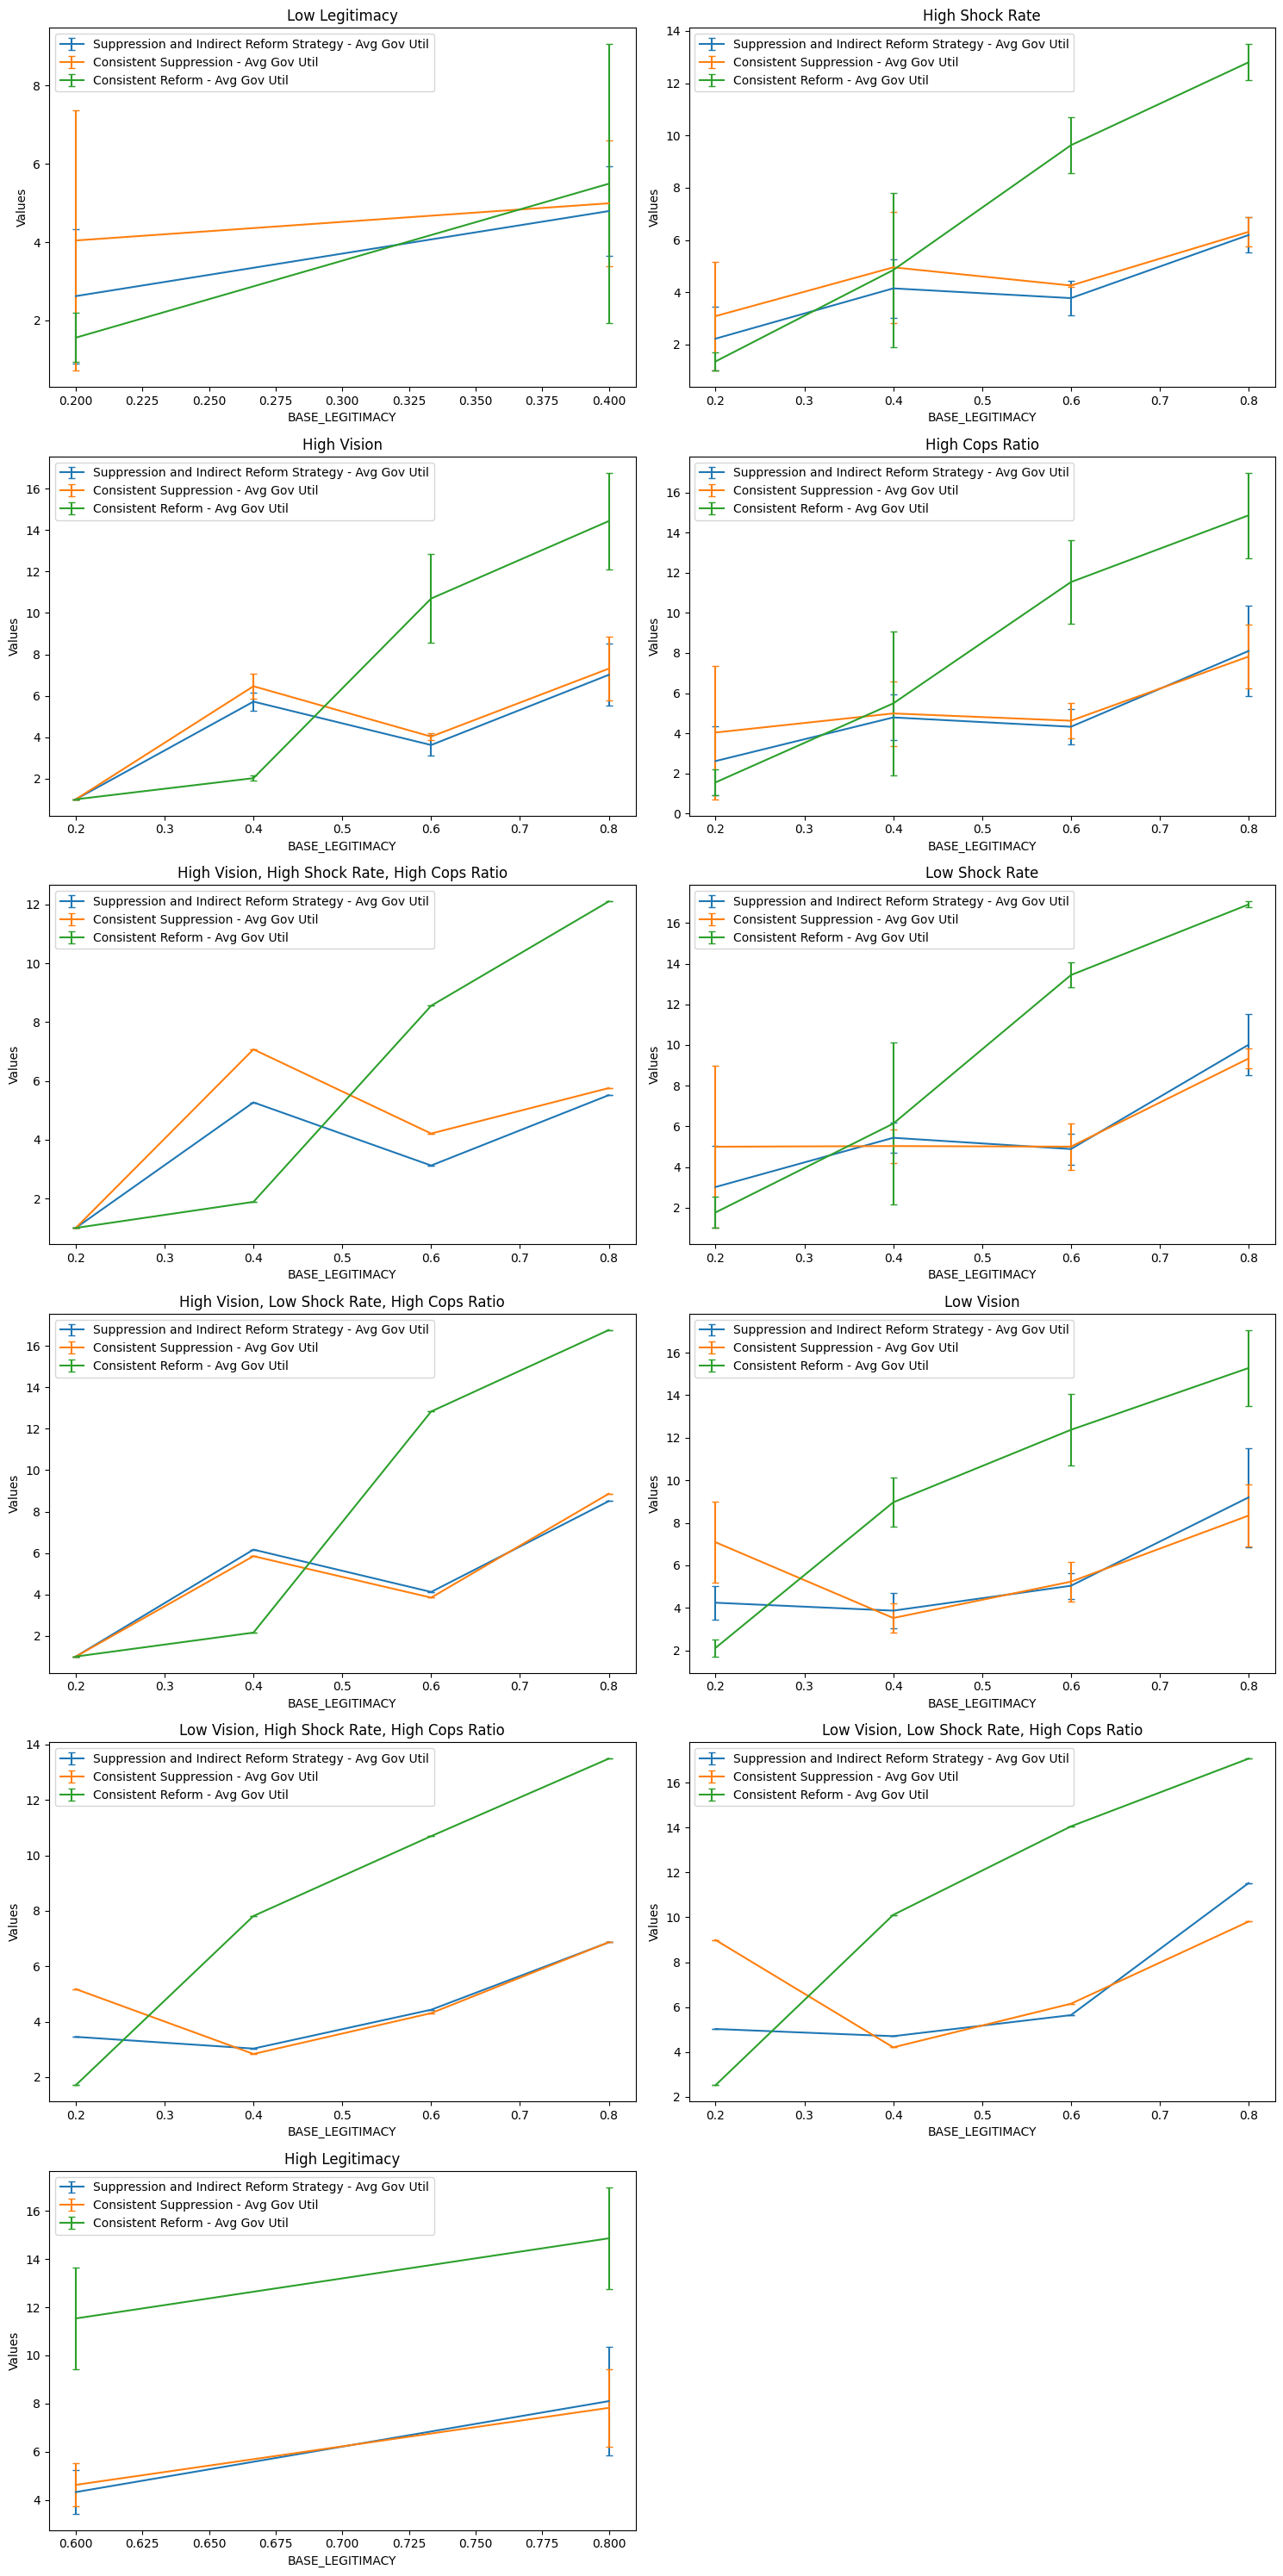

Plotting scenario: Low Legitimacy with 24 data points.
Plotting scenario: High Shock Rate with 24 data points.
Plotting scenario: High Vision with 24 data points.
Plotting scenario: High Cops Ratio with 48 data points.
Plotting scenario: High Vision, High Shock Rate, High Cops Ratio with 12 data points.
Plotting scenario: Low Shock Rate with 24 data points.
Plotting scenario: High Vision, Low Shock Rate, High Cops Ratio with 12 data points.
Plotting scenario: Low Vision with 24 data points.
Plotting scenario: Low Vision, High Shock Rate, High Cops Ratio with 12 data points.
Plotting scenario: Low Vision, Low Shock Rate, High Cops Ratio with 12 data points.
Plotting scenario: High Legitimacy with 24 data points.


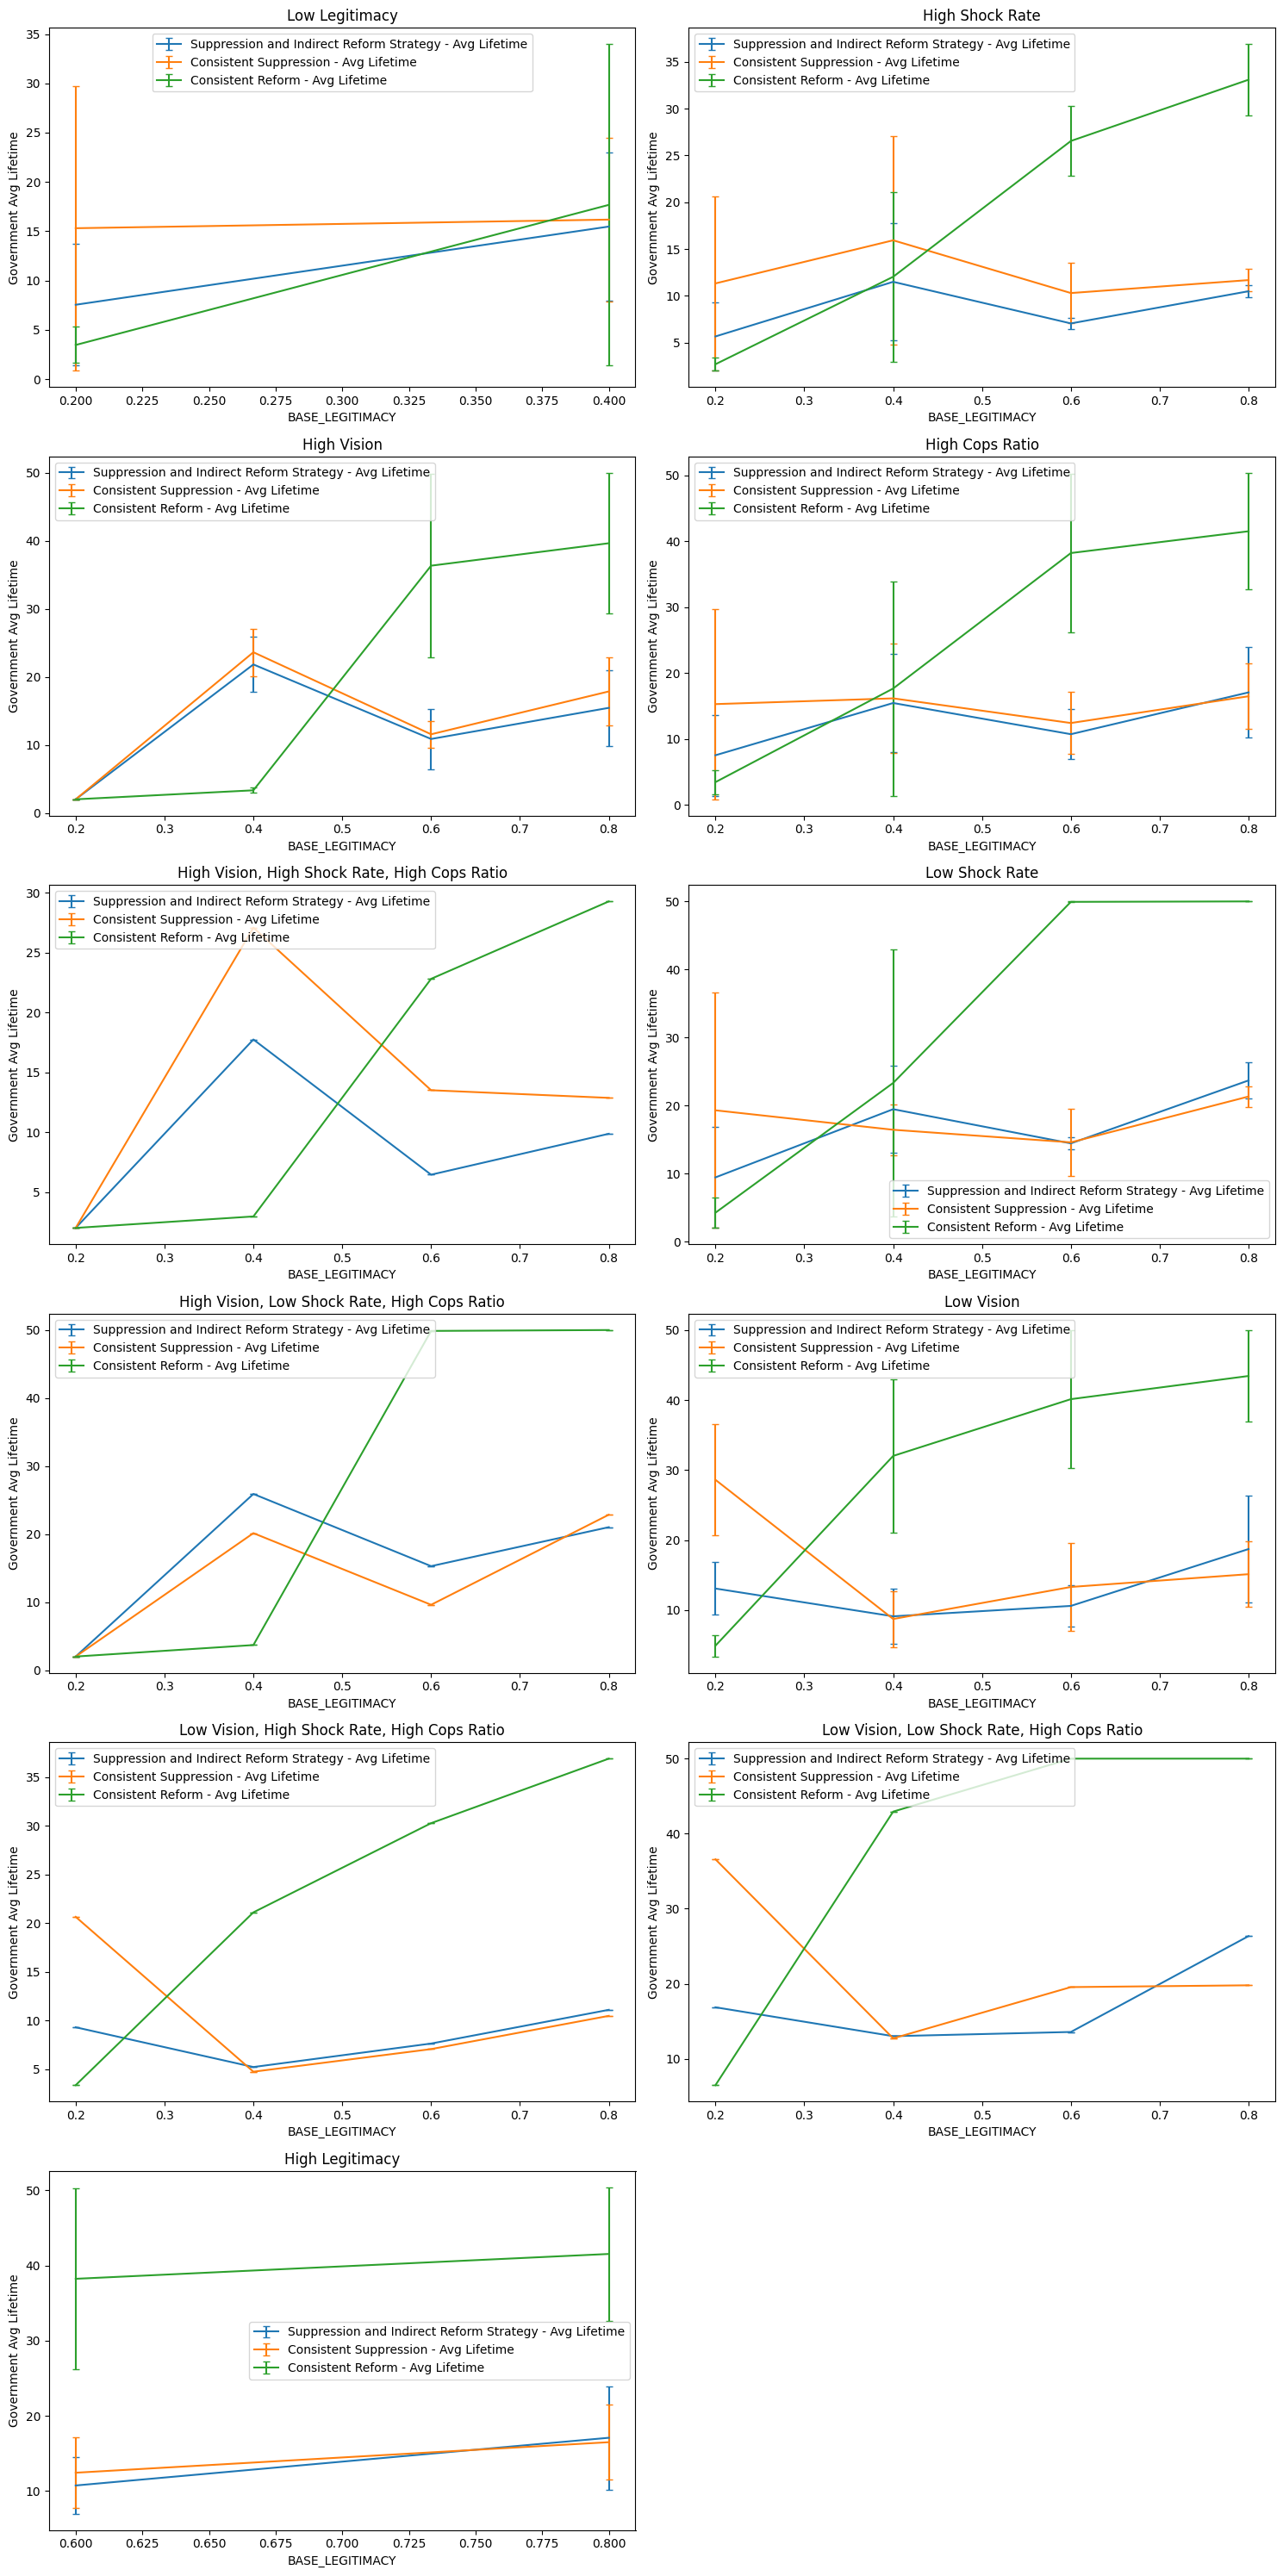

In [16]:
if __name__ == "__main__":
    main()